In [1]:
!pip install opencv-python

# Libraries

In [2]:
# Display
import matplotlib.pyplot as plt
# Directory
import cv2
import os
# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models

# Loss
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import losses, metrics

# Convert images to array of floats
import numpy as np

2024-12-05 11:27:56.613156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 11:28:00.598420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

device = "/GPU:0"

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-12-05 11:28:06.090622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-05 11:28:06.245540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-05 11:28:06.249753: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Display

In [4]:
# Display
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow((images[i].astype(as_type) + 1) / 2, cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


# Load Images Dataset

In [5]:
train = np.loadtxt("text_data/cat_data.txt")
train = train.reshape((29843, 64, 64, 3))
train.shape

(29843, 64, 64, 3)

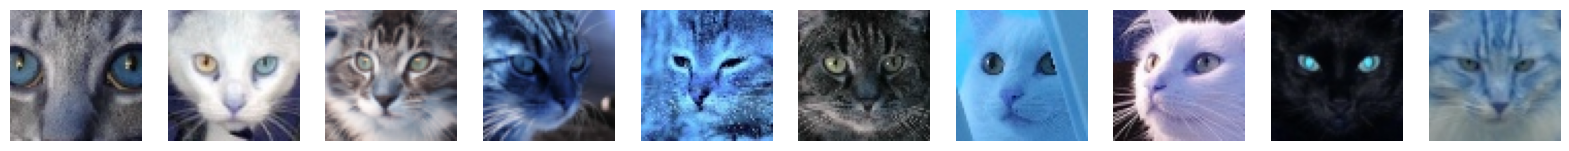

In [6]:
display(train[:10])

# Create Dataset

In [7]:
batch_size = 64

dataset = tf.data.Dataset.from_tensor_slices(train[:29824])

2024-12-05 11:31:09.480040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-05 11:31:09.483599: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-05 11:31:09.486744: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
dataset = dataset.shuffle(29825)

In [9]:
dataset = dataset.batch(batch_size)
# Prefetch done so I don't need to wait as long
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# GAN Start

In [10]:
# Variables
channels = 3
img_size = 64
img_shape = train[0].shape

noise_dim = 100

dropout = 0.3
relu_slope = 0.2
momentum = 0.9

epochs = 100
scale = 1

# Generator

In [11]:
class Generator(tf.keras.Model):
    def __init__(self, noise_dim, momentum):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.momentum = momentum

        # Define blocks (Currently using 4 major blocks)
        # Notes for self:
        #-When using leaky relu, 0.2 seems good for a GAN, since I am using negative 
        # input as well
        #-For batch normalization, numbers closer to 1 grab information from earlier 
        # back, which works well for stable data. I will use 0.85, since the cat picture
        # data is relatively stable.
        #-GANs for mnist (28, 28, 1) use 2-3 blocks, so I will use 4 blocks for my
        # larger images (64, 64, 3)
        #-Kernel of 5 since I want a lot of information, but I also want good effeciency


        self.reshape = layers.Reshape((1, 1, 100))
        self.conv2d_1 = layers.Conv2DTranspose(1024, kernel_size=4, strides=1, padding="valid", use_bias = False)
        self.batch_norm1 = layers.BatchNormalization(momentum=self.momentum)
        self.relu1 = layers.LeakyReLU(alpha=relu_slope) 

        self.conv2d_2 = layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same", use_bias = False)
        self.batch_norm2 = layers.BatchNormalization(momentum=self.momentum)
        self.relu2 = layers.LeakyReLU(alpha=relu_slope) 

        self.conv2d_3 = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias = False)
        self.batch_norm3 = layers.BatchNormalization(momentum=self.momentum)
        self.relu3 = layers.LeakyReLU(alpha=relu_slope) 

        self.conv2d_4 = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias = False)
        self.batch_norm4 = layers.BatchNormalization(momentum=self.momentum)
        self.relu4 = layers.LeakyReLU(alpha=relu_slope) 

        self.conv2d_5 = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias = False)
        self.batch_norm5 = layers.BatchNormalization(momentum=self.momentum)
        self.relu5 = layers.LeakyReLU(alpha=relu_slope) 

        self.conv2d_final = layers.Conv2DTranspose(3, kernel_size=4, strides=1, padding="same", activation="tanh", use_bias=False)

    def call(self, noise):
        x = self.reshape(noise)
        x = self.conv2d_1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)

        x = self.conv2d_2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)

        x = self.conv2d_3(x)
        x = self.batch_norm3(x)
        x = self.relu3(x)

        x = self.conv2d_4(x)
        x = self.batch_norm4(x)
        x = self.relu4(x)

        x = self.conv2d_5(x)
        x = self.batch_norm5(x)
        x = self.relu5(x)

        imgs = self.conv2d_final(x)

        return imgs
    
    def generate(self, batch_size, noise):
        if noise is None:
            noise = np.random.normal(0, 1, (batch_size, self.noise_dim))
        return self.call(tf.convert_to_tensor(noise, tf.float32))
    

In [12]:
# Quick check
generator = Generator(noise_dim, momentum=momentum)
images = generator.generate(batch_size, None)

/home/dsu/Desktop/Projects/.venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2024-12-05 11:31:25.011309: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


(64, 64, 64, 3)


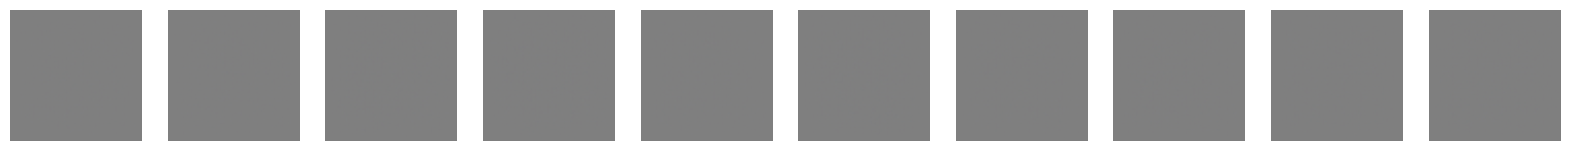

In [13]:
print(images.shape)
display(images.numpy()[:10])
# Yep that's noise

In [14]:
input_shape = (batch_size, noise_dim)
generator.build(input_shape)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (64, 1, 1, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (64, 4, 4, 1024)       │     1,638,400 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (64, 4, 4, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (64, 8, 8, 512)        │     8,388,608 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (64, 8, 8, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (64, 16, 16, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (64, 16, 16, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (64, 32, 32, 128)      │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (64, 32, 32, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (64, 64, 64, 64)       │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (64, 64, 64, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (64, 64, 64, 3)        │         3,072 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,790,528 (48.79 MB)

 Trainable params: 12,786,560 (48.78 MB)

 Non-trainable params: 3,968 (15.50 KB)

# Discriminator

In [15]:
class Discriminator(tf.keras.Model):
    def __init__(self, dropout):
        super(Discriminator, self).__init__()

        self.conv2d_1 = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)
        # no batch norm because first layer
        self.relu1 = layers.LeakyReLU(alpha = relu_slope)
        self.dropout1 = layers.Dropout(dropout)

        self.conv2d_2 = layers.Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)
        self.batch_norm2 = layers.BatchNormalization(momentum=momentum)
        self.relu2 = layers.LeakyReLU(alpha = relu_slope) 
        self.dropout2 = layers.Dropout(dropout)

        self.conv2d_3 = layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)
        self.batch_norm3 = layers.BatchNormalization(momentum=momentum)
        self.relu3 = layers.LeakyReLU(alpha = relu_slope) 
        self.dropout3 = layers.Dropout(dropout)

        self.conv2d_4 = layers.Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)
        self.batch_norm4 = layers.BatchNormalization(momentum=momentum)        
        self.relu4 = layers.LeakyReLU(alpha = relu_slope) 
        self.dropout4 = layers.Dropout(dropout)

        self.conv2d_5 = layers.Conv2D(1024, kernel_size=4, strides=1, padding="same", use_bias=False)
        self.batch_norm5 = layers.BatchNormalization(momentum=momentum)        
        self.relu5 = layers.LeakyReLU(alpha = relu_slope) 
        self.dropout5 = layers.Dropout(dropout)

        self.conv2d_final = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid", use_bias = False, activation = 'sigmoid')

        self.flatten = layers.Flatten()


 
    def call(self, inputs, training=False):
        x = self.conv2d_1(inputs)
        x = self.relu1(x)
        x = self.dropout1(x, training=training)

        x = self.conv2d_2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x, training=training)

        x = self.conv2d_3(x)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.dropout3(x, training=training)

        x = self.conv2d_4(x)
        x = self.batch_norm4(x)
        x = self.relu4(x)
        x = self.dropout4(x, training=training)

        #x = self.conv2d_5(x)
        #x = self.batch_norm5(x)
        #x = self.relu5(x)
        #x = self.dropout5(x, training=training)

        x = self.conv2d_final(x)

        x = self.flatten(x)
        
        return x

In [16]:
# Quick check
discriminator = Discriminator(dropout)
print(images[10].shape)
print(discriminator(images[:10]))


(64, 64, 3)
tf.Tensor(
[[0.5000077 ]
 [0.50002676]
 [0.50001556]
 [0.5000044 ]
 [0.50002617]
 [0.50001884]
 [0.50001985]
 [0.50000644]
 [0.50000334]
 [0.5000218 ]], shape=(10, 1), dtype=float32)


In [17]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (10, 32, 32, 64)       │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (10, 16, 16, 128)      │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (10, 16, 16, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (10, 8, 8, 256)        │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (10, 8, 8, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (10, 4, 4, 512)        │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (10, 4, 4, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (10, 4, 4, 1024)       │     8,388,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (10, 4, 4, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (10, 1, 1, 1)          │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (10, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,256 (42.60 MB)

 Trainable params: 11,164,416 (42.59 MB)

 Non-trainable params: 3,840 (15.00 KB)

# Build actual GAN

In [18]:
class CatGAN(models.Model):
    def __init__(self, discriminator, generator, noise_dim):
        super(CatGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise_dim = noise_dim

    def compile(self, dis_optimizer, gen_optimizer):
        super(CatGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.dis_optimizer = dis_optimizer
        self.gen_optimizer = gen_optimizer
        self.dis_loss_metric = metrics.Mean(name="dis_loss")
        self.gen_loss_metric = metrics.Mean(name="gen_loss")

    @property
    def metrics(self):
        return [self.dis_loss_metric, self.gen_loss_metric]

    def train_step(self, real_images):

        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            # fake images
            fake_images = self.generator.generate(batch_size, None)
            # do predictions
            real_predictions = self.discriminator(real_images, training = True)
            fake_predictions = self.discriminator(fake_images, training = True)

            # label data
            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + 0.1 * tf.random.uniform(tf.shape(real_predictions))
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - 0.1 * tf.random.uniform(tf.shape(fake_predictions))

            # calculate loss
            dis_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            dis_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            dis_loss = (dis_real_loss + dis_fake_loss) / 2.0

            gen_loss = self.loss_fn(real_labels, fake_predictions)

        grad_dis = dis_tape.gradient(dis_loss, self.discriminator.trainable_variables)
        grad_gen = gen_tape.gradient(gen_loss, self.generator.trainable_variables)

        self.dis_optimizer.apply_gradients(zip(grad_dis, discriminator.trainable_variables)) 
        self.gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))

        self.dis_loss_metric.update_state(dis_loss)
        self.gen_loss_metric.update_state(gen_loss)

        return {m.name: m.result() for m in self.metrics}

catGAN = CatGAN(discriminator=discriminator, generator=generator, noise_dim=noise_dim)


catGAN.compile(
    dis_optimizer=Adam(
        learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999
    ),
    gen_optimizer=Adam(
        learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999
    ),
)

inp_shape = (batch_size, img_shape, img_shape, channels)
catGAN.build(inp_shape)
catGAN.summary()

Model: "cat_gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ discriminator (Discriminator)   │ ?                      │    11,168,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator (Generator)           │ ?                      │    12,790,528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,958,784 (91.40 MB)

 Trainable params: 23,950,976 (91.37 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [19]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import math

n_batches = math.ceil(29843/batch_size)

checkpoint_cb = ModelCheckpoint(
    "checkpointGAN/model_checkpoint_{epoch:02d}.weights.h5",
    save_weights_only=True,
    save_best_only = False,
    verbose=1,
    save_freq=10*n_batches
)

class ModelMonitor(Callback):
    def __init__(self, catGAN):
        self.catGAN = catGAN

    def on_epoch_end(self, epoch, logs=None):
        # update scale
        #self.catGAN.scale = 1 - (epoch / epochs)
        # generate image
        if epoch % 1 == 0:
            gen_imgs = self.catGAN.generator.generate(batch_size, None)
            img = ((gen_imgs[0] + 1) / 2) * 255
            img = img.numpy()
            img = array_to_img(img)
            img.save(os.path.join("text_data", "img_" + str(epoch / 10) + ".png"))
        


In [20]:
hist = catGAN.fit(dataset, epochs=epochs, callbacks=[ModelMonitor(catGAN), checkpoint_cb])

Epoch 1/100


2024-12-05 11:31:28.826404: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2931818496 exceeds 10% of free system memory.
2024-12-05 11:31:35.047448: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
I0000 00:00:1733419898.315258   27778 service.cc:145] XLA service 0x7c5060008150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733419898.315333   27778 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
W0000 00:00:1733419898.778455   27778 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform_1/RandomUniform
2024-12-05 11:31:39.022977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPR

  3/466 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - dis_loss: 1.5601 - gen_loss: 2.5475 

I0000 00:00:1733419935.233270   27778 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


466/466 ━━━━━━━━━━━━━━━━━━━━ 67s 44ms/step - dis_loss: 0.4812 - gen_loss: 4.6985
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - dis_loss: 0.4584 - gen_loss: 2.7571
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - dis_loss: 0.4298 - gen_loss: 2.8808
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - dis_loss: 0.4599 - gen_loss: 2.1942
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - dis_loss: 0.4980 - gen_loss: 1.9201
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - dis_loss: 0.5015 - gen_loss: 1.6709
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - dis_loss: 0.5485 - gen_loss: 1.4473
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - dis_loss: 0.5528 - gen_loss: 1.3279
Epoch 9/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - dis_loss: 0.5937 - gen_loss: 1.2169
Epoch 10/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - dis_loss: 0.5960 - gen_loss: 1.1110
Epoch 11/100
  9/466 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - dis_loss: 0.6474 - gen_

2024-12-05 11:35:35.174012: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


466/466 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - dis_loss: 0.6248 - gen_loss: 1.0462
Epoch 12/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - dis_loss: 0.6194 - gen_loss: 1.0248
Epoch 13/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - dis_loss: 0.6270 - gen_loss: 1.0009
Epoch 14/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - dis_loss: 0.6361 - gen_loss: 0.9954
Epoch 15/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - dis_loss: 0.6507 - gen_loss: 0.9425
Epoch 16/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - dis_loss: 0.6559 - gen_loss: 0.9186
Epoch 17/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - dis_loss: 0.6673 - gen_loss: 0.8804
Epoch 18/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - dis_loss: 0.6552 - gen_loss: 0.9029
Epoch 19/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - dis_loss: 0.6574 - gen_loss: 0.8854
Epoch 20/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - dis_loss: 0.6691 - gen_loss: 0.8672
Epoch 21/100
 19/466 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - dis_loss: 0.660

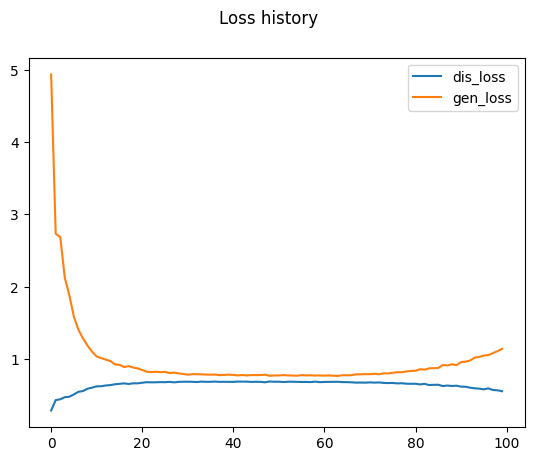

In [21]:
plt.suptitle("Loss history")
plt.plot(hist.history["dis_loss"], label="dis_loss")
plt.plot(hist.history["gen_loss"], label="gen_loss")
plt.legend()
plt.show()

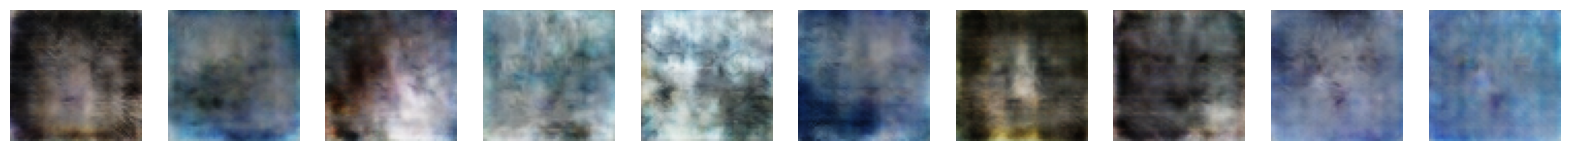

In [24]:
imgs = catGAN.generator.generate(batch_size, None)
display(imgs.numpy()[:10])

In [23]:
recon = CatGAN(generator, discriminator, noise_dim)
recon.load_weights('checkpoint/model_checkpoint_30.weights.h5')

ValueError: You are loading weights into a model that has not yet been built. Try building the model first by calling it on some data or by using `build()`.

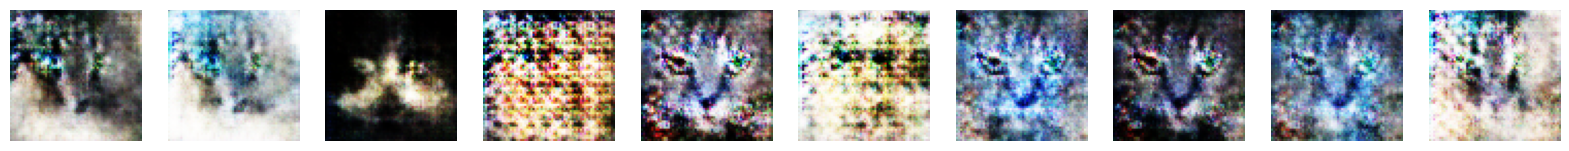

In [30]:
batch = recon.generator.generate(batch_size, None)
display(batch.numpy()[:10])